In [10]:
#!/usr/bin/env python
import git
import sys
import datetime
from pathlib import Path
sys.path.append('/home/bij/Projects/fdtd/')
import math
import time
import fdtd
import fdtd.backend as bd
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.optim as optim
import torchvision
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import scipy
from autoencoder import AutoEncoder
import argparse
from os import listdir
from os.path import isfile, join
import util
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure

parser = argparse.ArgumentParser(description='Process args.')
parser.add_argument('-f', '--load-file', type=str, default=None,
                    help='File to load params from before training starts. Overrides --load-step.')
parser.add_argument('-l', '--load-step', type=str, default='0',
                    help='Where to start training. If latest, will start at the latest checkpoint.')
parser.add_argument('-s', '--save-steps', type=int, default='1000',
                    help='How often to save the model.')
parser.add_argument('-c', '--coverage-ratio', type=float, default=1.0,
                    help='How much distance a wave can cover as a proportion of the diagonal length of the sim.')
parser.add_argument('-m', '--max-steps', type=int, default='1000000000000000',
                    help='How many steps to train.')
parser.add_argument('-d', '--dry-run', type=bool, default=False,
                    help='If true, does not save model checkpoint.')
parser.add_argument('-rog', '--reset-grid-optim', default=False, action='store_true',
                    help='If true, loads completely new params for the grid and optimizer.')
parser.add_argument('-is', '--image-size', type=int, default=40,
                    help='Size of each side of the image. Determines grid size.')
parser.add_argument('-sc', '--image-scaler', type=int, default=1,
                    help='How much to scale the entire simulation by (changes the dimensions of the model).')
parser.add_argument('-oc', '--old-scaler', type=int, default=1,
                    help='If the loaded file was scaled, that scaler value.')
parser.add_argument('-bem', '--bypass-em', default=False, action='store_true',
                    help='If set, will disable the EM component of the model.')
parser.add_argument('-gray', '--grayscale', default=False, action='store_true',
                    help='If set, will force the input and output images to be grayscale.')
parser.add_argument('-thw', '--target-half-way', default=False, action='store_true',
                    help='If set, will only produce loss for the timestep halfway up the coverage ratio.')
parser.add_argument('-sds', '--source-down-scaler', type=int, default=1, 
                    help='How much to stride sources in the cortical substrate.')
parser.add_argument('-sgd', '--use-sgd', default=False, action='store_true',
                    help='If set, will switch to SGD instead of Adam. Useful for finetuning.')
parser.add_argument('-ti', '--target-img', default=None, action='store_true',
                    help='If set, will only process this image file.')
args = parser.parse_args()

#args.load_file = 'model_checkpoints/stability-improvements-simple/md_000000039000.pt'
#args.load_file = 'model_checkpoints/stability-improvements-simple/md_000000047000.pt'
#args.load_file = 'model_checkpoints/stability-improvements-simple-limitnonlin/md_000000093859.pt'
args.load_file = 'model_checkpoints/stability-improvements-simple-limitnonlin/md_000000094745.pt'

args.grayscale = True
#args.image_scaler = 4
args.image_scaler = 5
args.coverage_ratio = 4

def get_sorted_paths(directory_list, target_ext='.png'):
    path_list = []
    for directory in directory_list:
        paths = [join(directory,f) for f in listdir(directory) if isfile(join(directory, f)) and f.endswith(target_ext)]
        print(f'Found {len(paths)} files in {directory}')
        path_list += paths
    path_list.sort()
    return path_list

def scale_img(img, s=2):
    return torchvision.transforms.functional.resize(img, size=(img.shape[-2] * s, img.shape[-1] * s), interpolation=torchvision.transforms.InterpolationMode.NEAREST)

#img_paths = get_sorted_paths(['./optical_illusions/'])
img_paths = [#'./optical_illusions/robinson_1.png',
             #'./optical_illusions/robinson_2.png',
     #'./optical_illusions/robinson_3.png',
     #'./optical_illusions/Cornsweet_illusion.png',
     #'./optical_illusions/Ehrenstein_Illusion.png',
     #'./optical_illusions/ehrenstein_illusion.png',
     #'./optical_illusions/dots_Brightness-Optical-Illusion.png',
     './optical_illusions/illusory_brigntness.png',
     #'./optical_illusions/illusory_brigntness_reverse.png',
     #'./optical_illusions/rectangle_Brightness-Optical-Illusion2.png'
            ]

# ## Set Backend
backend_name = "torch"
fdtd.set_backend(backend_name)
if(backend_name.startswith("torch.cuda")):
    device = "cuda"
else:
    device = "cpu"

In [11]:
img_paths

['./optical_illusions/illusory_brigntness.png']

In [12]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((args.image_size*args.image_scaler, args.image_size*args.image_scaler))])

img_file = img_paths[0]
print(img_file.split('/')[-1].split('.')[0])
img = Image.open(img_file)
print('Image shape: ', np.array(img).shape)
img = image_transform(img)[None, ...]
if(args.grayscale):
    img = torchvision.transforms.Grayscale()(img)[None, 0, ...]
else:
    img = torchvision.transforms.Grayscale()(img)
print('Image shape: ', img.shape)
ih, iw = tuple(img.shape[2:4])
print('ih, iw: ', ih, iw)

# Physics constants
WAVELENGTH = 1550e-9 # meters
SPEED_LIGHT: float = 299_792_458.0  # [m/s] speed of light
GRID_SPACING = 0.1 * WAVELENGTH # meters



# Size of grid boundary layer
bw = 10
# Create FDTD Grid
grid_h, grid_w = (ih+bw*2, iw+bw*2)
print('Grid height and width: ', grid_h, grid_w)
# Boundaries with width bw
grid = fdtd.Grid(
    (grid_h, grid_w, 1),
    grid_spacing=GRID_SPACING,
    permittivity=1.0,
    permeability=1.0,
)

# Calculate how long it takes a wave to cross the entire grid.
grid_diag_cells = math.sqrt(grid_h**2 + grid_w**2)
grid_diag_len = grid_diag_cells * GRID_SPACING
grid_diag_steps = int(grid_diag_len/SPEED_LIGHT/grid.time_step)+1
print('Time steps to cover entire grid: ', grid_diag_steps)
# The number of steps is based on the coverage ratio.
if(args.target_half_way):
    em_steps = int(grid_diag_steps*args.coverage_ratio/2)
else:
    em_steps = int(grid_diag_steps*args.coverage_ratio)
print('Time steps the grid will run for: ', em_steps)


# Create learnable objects at the boundaries
grid[:, :, 0] = fdtd.PeriodicBoundary(name="zbounds")

# Creat the cortical column sources
grid[bw:bw+ih,bw:bw+iw,0] = fdtd.CorticalColumnPlaneSource(
    period = WAVELENGTH / SPEED_LIGHT,
    polarization = 'x', # BS value, polarization is not used.
    name = 'cc',
    source_stride = args.source_down_scaler,
)

# Object defining the cortical column substrate 
grid[bw:-bw, bw:-bw, :] = fdtd.LearnableAnisotropicObject(permittivity=2.5, is_substrate=True, name="cc_substrate", device=device)

torch.autograd.set_detect_anomaly(True)
# The weights for the reconstruction loss at each em time step. 
loss_step_weights = torch.ones(em_steps, device=device)/em_steps
#loss_step_weights = torch.nn.Parameter(torch.reshape(loss_step_weights, (-1, 1, 1, 1, 1)))
loss_step_weights.requires_grad = True
softmax = torch.nn.Softmax(dim=0)

illustory_brightness# Initialize the model and grid with default params.
if(args.grayscale):
    chans = 1
else:
    chans = 3
model = AutoEncoder(num_em_steps=em_steps, grid=grid, input_chans=chans, output_chans=chans, source_stride=args.source_down_scaler, bypass_em=args.bypass_em).to(device)
print('All grid objects: ', [obj.name for obj in grid.objects])
grid_params_to_learn = []
# The weights for the loss.
grid_params_to_learn += [loss_step_weights]
# Nonlinearity weights for the substrate.
grid_params_to_learn += [util.get_object_by_name(grid, 'cc_substrate').nonlin_conv.weight]
grid_params_to_learn += [util.get_object_by_name(grid, 'cc_substrate').nonlin_conv.bias]


# Load saved params for model and optimizer.
reset_optimizer = False
if(args.load_file is not None):
    start_step = int(args.load_file.split('/')[-1].split('_')[-1].split('.')[0])
    print('Loading model {0}. Starting at step {1}.'.format(args.load_file, start_step))
    optimizer_path = args.load_file.rsplit('.', 1)[0] + '.opt'
    grid_path = args.load_file.rsplit('.', 1)[0] + '.grd'
    model.load_state_dict(torch.load(args.load_file))
    # Load grid params and interpolate them if necessary
    with torch.no_grad():
        load_grid_params_to_learn = torch.load(grid_path)
        for idx, tensor in enumerate(load_grid_params_to_learn):
            if(tensor.shape == grid_params_to_learn[idx][...].shape):
                grid_params_to_learn[idx][...] = tensor[...]
                print('Loaded grid param {0} with shape: {1}'.format(idx, tensor.shape)) 
            else:
                # Interpolate the thing....
                print('INFO: Shapes are mismatched: {0} vs {1}'.format(tensor[...].shape, grid_params_to_learn[idx][...].shape))
                reset_optimizer = True
else:
    print('Starting model at step 0')
    start_step = 0
    optimizer_path = None
    grid_path = None



illusory_brigntness
Image shape:  (800, 800, 3)
Image shape:  torch.Size([1, 1, 200, 200])
ih, iw:  200 200
Grid height and width:  220 220
Time steps to cover entire grid:  445
Time steps the grid will run for:  1780
All grid objects:  ['cc_substrate']
Loading model model_checkpoints/stability-improvements-simple-limitnonlin/md_000000094745.pt. Starting at step 94745.
Loaded grid param 0 with shape: torch.Size([1780])
Loaded grid param 1 with shape: torch.Size([9, 2, 1, 1])
Loaded grid param 2 with shape: torch.Size([9])


In [13]:
img.shape[-1]*3

600

In [14]:
img_save.shape

NameError: name 'img_save' is not defined

In [16]:
# Get sample from training data
em_step_loss_weight_dist = softmax(loss_step_weights)
argmax_step = torch.argmax(torch.squeeze(loss_step_weights))

output_img_scale = 3

# Only process one image if this is set
if(args.target_img):
    img_paths = [args.target_img]

for img_file in img_paths:
    # Reset the grid
    grid.reset()
    # Load an image
    img_name = img_file.split('/')[-1].split('.')[0]
    print('Processing: ', img_name)
    img = Image.open(img_file)
    img = image_transform(img)[None, ...]
    if(args.grayscale):
        img = torchvision.transforms.Grayscale()(img)[None, 0, ...]
    else:
        img = torchvision.transforms.Grayscale()(img)
    
    # Get the path of the test strip
    illusion_path, illusion_filename = img_file.rsplit('/', 1)
    test_strip_pref = illusion_path + '/test_strips/' + illusion_filename.split('.')[0]
    test_strip_file_a = test_strip_pref + '_teststrip_part_a.png'
    test_strip_file_b = test_strip_pref + '_teststrip_part_b.png'
    print('Opening image {0} with test strip file {1}'.format(img_file, test_strip_file_a))
    
    try:
        test_strip_img_a = np.array(Image.open(test_strip_file_a))
    except:
        print('Could not find {0}, skipping'.format(test_strip_file_a))
        continue
        #test_strip_img_a = np.ones((3, img.shape[1], img.shape[2]))
    try:
        test_strip_img_b = np.array(Image.open(test_strip_file_b))
    except:
        print('Could not find {0}, making zeros.'.format(test_strip_file_b))
        test_strip_img_b = np.zeros_like(test_strip_img_a)
    # Make sure it is binary.
    assert np.sum(((test_strip_img_a > 0) * (test_strip_img_a < 1)).astype(np.int)) <= 0
    assert np.sum(((test_strip_img_b > 0) * (test_strip_img_b < 1)).astype(np.int)) <= 0
    test_strip_img_a = image_transform(test_strip_img_a)[None, ...]
    test_strip_img_b = image_transform(test_strip_img_b)[None, ...]
    # Re-binarize after the resize.
    test_strip_img_a = (test_strip_img_a > 0.5).float()
    test_strip_img_b = (test_strip_img_b > 0.5).float()
    print('Test strip stats: ', torch.mean(test_strip_img_a), torch.min(test_strip_img_a), torch.max(test_strip_img_a))
    print('Test strip stats: ', torch.mean(test_strip_img_b), torch.min(test_strip_img_b), torch.max(test_strip_img_b))

    for em_step, (img_hat_em, em_field) in enumerate(model(img, summary_writer=None, train_step=0)):
        print(img_name, '\tem step: ', em_step, em_steps, end='\r')
        
        # Save the em field and energy at the target step.
        e_field_img = em_field[0:3,...]
        h_field_img = em_field[3:6,...]
        
        #if(em_step == argmax_step):
        #if(em_step % 10 == 0):
        if(True):
            masked_output_a = test_strip_img_a * torch.unsqueeze(img_hat_em, 0)
            masked_output_b = test_strip_img_b * torch.unsqueeze(img_hat_em, 0)
            masked_output_a = torch.squeeze(masked_output_a)
            masked_output_b = torch.squeeze(masked_output_b)
            masked_output_a = torch.sum(masked_output_a, axis=-2)
            masked_output_b = torch.sum(masked_output_b, axis=-2)
            # Sum the input image over the y dimension.
            input_img_masked_sum = test_strip_img_a * img
            input_img_masked_sum = torch.squeeze(input_img_masked_sum)
            input_img_masked_sum = torch.sum(input_img_masked_sum, axis=-2)
        
        dpi = 100    
        fig = Figure(figsize=(img.shape[-1]*output_img_scale//dpi, img.shape[-1]*output_img_scale//dpi), dpi=dpi)
        fig.tight_layout(pad=0)
        canvas = FigureCanvasAgg(fig)
        # Do some plotting here
        ax = fig.add_subplot(111)
        ax.plot(masked_output_a.detach().numpy())
        ax.plot(input_img_masked_sum.detach().numpy())
        #ax.plot([1, 2, 3])
        # Retrieve a view on the renderer buffer
        canvas.draw()
        buf = canvas.buffer_rgba()
        # convert to a NumPy array
        plot_img = torch.from_numpy(np.transpose(np.asarray(buf).astype(np.float32), (2,0,1))[0:3, ...])/255.0
        
            #plt.show()
        # Add the argmaxxed images to tensorboard
        if(args.grayscale):
            img_save =  scale_img(img.expand(-1, 3, -1, -1), s=3)
            #img_hat_em_save =  img_hat_em_save.expand(3, -1, -1)
            img_hat_em_save =  scale_img(img_hat_em, s=3).expand(3, -1, -1)
            test_strip_img_a_save = scale_img(test_strip_img_a, s=3).expand(-1, 3, -1, -1)[0]
            masked_output_a_save = scale_img(test_strip_img_a * torch.unsqueeze(img_hat_em, 0), s=3).expand(-1, 3, -1, -1)[0]
        img_grid = torchvision.utils.make_grid([img_save[0,...], img_hat_em_save, masked_output_a_save, plot_img,
            util.norm_img_by_chan(scale_img(e_field_img, s=3)), 
            util.norm_img_by_chan(scale_img(h_field_img, s=3))], nrow=3, pad_value=4)
        save_image(img_grid, './images/{0}_step_{1}.png'.format(img_name, str(em_step).zfill(12)))
        #save_image(util.norm_img_by_chan(scale_img(h_field_img, s=3)), './h_fields/h_field2_{0}_step_{1}.png'.format(img_name, str(em_step).zfill(12)))
        
    print('')
    


Processing:  illusory_brigntness
Opening image ./optical_illusions/illusory_brigntness.png with test strip file ./optical_illusions/test_strips/illusory_brigntness_teststrip_part_a.png
Test strip stats:  tensor(0.5374, dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(1., dtype=torch.float32)
Test strip stats:  tensor(0.1359, dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(1., dtype=torch.float32)


/tmp/ipykernel_2675686/1658163541.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert np.sum(((test_strip_img_a > 0) * (test_strip_img_a < 1)).astype(np.int)) <= 0
/tmp/ipykernel_2675686/1658163541.py:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note li

illusory_brigntness 	em step:  1779 1780


# Test illusions with two contrasting regions

In [44]:
brightness_files = get_sorted_paths(['./images/'])
brightness_files = [f for f in brightness_files if 'illusory' in f]
len(brightness_files)

Found 5016 files in ./images/


1780

In [54]:
# Get the avg image
for idx, f in enumerate(brightness_files):
    img = Image.open(f)
    if(idx == 0):
        img_avg = np.zeros_like(img, dtype=np.float64)
    img_avg += img
    print(idx)
img_avg /= len(brightness_files)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

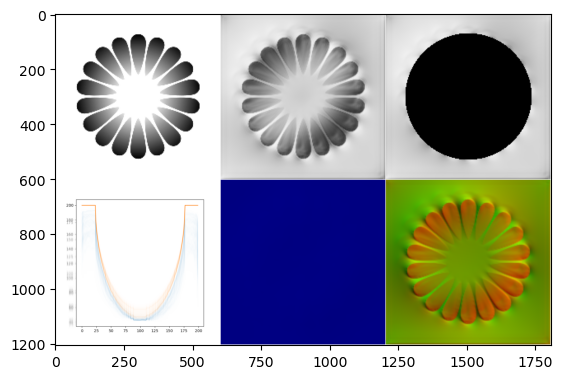

In [55]:
plt.imshow(img_avg/255.0)